In [74]:
# Library importieren
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib # um modell zu speichern

# matplotlib design festlegen
%matplotlib inline 

In [75]:
# dataset laden
file_path = "procrastination_data.csv"
df_original = pd.read_csv(file_path)

In [76]:
df_original.head()

,Timestamp,study_year,socio-economic_background,assignment_delay_frequency,procrastination_reasons,assignment_submission_timing,last_minute_exam_preparation,effect_of_procrastination_on_grades,procrastination_and_grade_outcome,stress_due_to_procrastination,study_hours_per_week,cgpa,use_of_time_management,procrastination_management_training,procrastination_recovery_strategies,hours_spent_on_mobile_non_academic,study_session_distractions
0,11/4/2024 9:39:00,Fourth Year,Middle,Always,"Lack of interest, Health issues",Never,Yes,Significantly,Yes,Significantly,0-5 hours,2.50 - 2.99,Always,Yes,Yes,1-2 hours,Sometimes
1,11/4/2024 11:11:00,Third Year,Middle,Often,"Procrastination due to lack of resources, Heal...",Occasionally,Yes,Moderately,Yes,Not at all,0-5 hours,3.00 - 3.49,Never,Yes,No,More than 4 hours,Sometimes
2,11/4/2024 11:44:00,Second Year,Lower-middle,Occasionally,"Distractions (e.g., social media), Health issues",Sometimes,Yes,Not at all,No,Moderately,6-10 hours,3.00 - 3.49,Never,No,Yes,3-4 hours,Occasionally
3,11/4/2024 12:05:00,Fourth Year,High,Always,"Procrastination due to lack of resources, Heal...",Sometimes,Yes,Not at all,Yes,Significantly,0-5 hours,Below 2.50,Never,No,No,More than 4 hours,Often
4,11/4/2024 12:48:00,Third Year,Upper-middle,Sometimes,Lack of interest,Never,No,Significantly,No,Slightly,6-10 hours,3.50 - 3.74,Sometimes,Yes,No,More than 4 hours,Always


In [77]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Timestamp                            451 non-null    object
 1   study_year                           451 non-null    object
 2   socio-economic_background            445 non-null    object
 3   assignment_delay_frequency           451 non-null    object
 4   procrastination_reasons              451 non-null    object
 5   assignment_submission_timing         451 non-null    object
 6   last_minute_exam_preparation         451 non-null    object
 7   effect_of_procrastination_on_grades  451 non-null    object
 8   procrastination_and_grade_outcome    451 non-null    object
 9   stress_due_to_procrastination        451 non-null    object
 10  study_hours_per_week                 451 non-null    object
 11  cgpa                                 441 non-

In [78]:
df_original.describe()

,Timestamp,study_year,socio-economic_background,assignment_delay_frequency,procrastination_reasons,assignment_submission_timing,last_minute_exam_preparation,effect_of_procrastination_on_grades,procrastination_and_grade_outcome,stress_due_to_procrastination,study_hours_per_week,cgpa,use_of_time_management,procrastination_management_training,procrastination_recovery_strategies,hours_spent_on_mobile_non_academic,study_session_distractions
count,451,451,445,451,451,451,451,451,451,451,451,441,446,448,451,451,451
unique,449,4,5,5,116,5,2,4,2,4,4,5,5,2,2,3,5
top,11/19/2024 9:02:00,Third Year,Upper-middle,Often,Health issues,Never,Yes,Slightly,Yes,Significantly,0-5 hours,3.00 - 3.49,Always,No,No,More than 4 hours,Often
freq,2,218,98,185,24,109,242,116,247,125,289,174,102,228,242,169,106


In [79]:
df_original.columns.tolist()

['Timestamp',
 'study_year',
 'socio-economic_background',
 'assignment_delay_frequency',
 'procrastination_reasons',
 'assignment_submission_timing',
 'last_minute_exam_preparation',
 'effect_of_procrastination_on_grades',
 'procrastination_and_grade_outcome',
 'stress_due_to_procrastination',
 'study_hours_per_week',
 'cgpa',
 'use_of_time_management',
 'procrastination_management_training',
 'procrastination_recovery_strategies',
 'hours_spent_on_mobile_non_academic',
 'study_session_distractions']

In [80]:
df_original.isnull().sum()

Timestamp                               0
study_year                              0
socio-economic_background               6
assignment_delay_frequency              0
procrastination_reasons                 0
assignment_submission_timing            0
last_minute_exam_preparation            0
effect_of_procrastination_on_grades     0
procrastination_and_grade_outcome       0
stress_due_to_procrastination           0
study_hours_per_week                    0
cgpa                                   10
use_of_time_management                  5
procrastination_management_training     3
procrastination_recovery_strategies     0
hours_spent_on_mobile_non_academic      0
study_session_distractions              0
dtype: int64

In [81]:
df_original["assignment_delay_frequency"].value_counts()

assignment_delay_frequency
Often           185
Sometimes        84
Occasionally     69
Always           62
Never            51
Name: count, dtype: int64

In [82]:
df = df_original.copy() # df_original kopieren

In [83]:
df = df.drop(columns=["Timestamp"]) # timestamp ist irrelevant für unser ML

In [84]:
# our target column is "assignment_delay_frequency"
# we want to predict the procrastination risk on three level this is why we have to map the values of the column to three levels
# therefore we define the functino map_to_3_levels
# then we map it onto the new column "procrastination_risk_level"

def map_to_3_levels(value):
    if value in ["Never", "Occasionally"]:
        return 0 # Low Risk
    elif value == "Sometimes":
        return 1 # Medium Risk
    elif value in ["Often", "Always"]:
        return 2 # High Risk
    return np.nan 
    
df["procrastination_risk_level"] = df["assignment_delay_frequency"].apply(map_to_3_levels)
df["procrastination_risk_level"].value_counts(dropna=False).sort_index()

# Simple Missing Value Handling (Mode Imputation for all object columns, Median for numeric)
# für fehlende Werte nutzen wir modus imputation da wir nur kategorische Werte haben
columns_to_impute = [col for col in df.columns if col != "procrastination_risk_level"]
for col in columns_to_impute:
    df[col] = df[col].fillna(df[col].mode()[0])

In [85]:
df.isnull().sum() # imputation war erfolgreich weil keine null values mehr vorhanden sind

study_year                             0
socio-economic_background              0
assignment_delay_frequency             0
procrastination_reasons                0
assignment_submission_timing           0
last_minute_exam_preparation           0
effect_of_procrastination_on_grades    0
procrastination_and_grade_outcome      0
stress_due_to_procrastination          0
study_hours_per_week                   0
cgpa                                   0
use_of_time_management                 0
procrastination_management_training    0
procrastination_recovery_strategies    0
hours_spent_on_mobile_non_academic     0
study_session_distractions             0
procrastination_risk_level             0
dtype: int64

In [86]:
# wir wollen nur die Spalten / Feature die wir realistisch in Form eines Fragebogens von den Studenten abfragen können
features_to_keep = [
    "study_year",
    "socio-economic_background",
    "last_minute_exam_preparation",
    "study_hours_per_week",
    "cgpa",
    "use_of_time_management",
    "hours_spent_on_mobile_non_academic",
    "study_session_distractions",
    "procrastination_risk_level"
]
    
df = df[features_to_keep]

df.head()

,study_year,socio-economic_background,last_minute_exam_preparation,study_hours_per_week,cgpa,use_of_time_management,hours_spent_on_mobile_non_academic,study_session_distractions,procrastination_risk_level
0,Fourth Year,Middle,Yes,0-5 hours,2.50 - 2.99,Always,1-2 hours,Sometimes,2
1,Third Year,Middle,Yes,0-5 hours,3.00 - 3.49,Never,More than 4 hours,Sometimes,2
2,Second Year,Lower-middle,Yes,6-10 hours,3.00 - 3.49,Never,3-4 hours,Occasionally,0
3,Fourth Year,High,Yes,0-5 hours,Below 2.50,Never,More than 4 hours,Often,2
4,Third Year,Upper-middle,No,6-10 hours,3.50 - 3.74,Sometimes,More than 4 hours,Always,1


In [87]:
df.shape

(451, 9)

In [88]:
df.columns.tolist()

['study_year',
 'socio-economic_background',
 'last_minute_exam_preparation',
 'study_hours_per_week',
 'cgpa',
 'use_of_time_management',
 'hours_spent_on_mobile_non_academic',
 'study_session_distractions',
 'procrastination_risk_level']

In [89]:
X = df.drop(columns=["procrastination_risk_level"]) # alle ausser zielvariable
y = df["procrastination_risk_level"] # zielvariable

# one hot encoding kategorische variablen
X_encoded = pd.get_dummies(X, drop_first=True, dtype=int)

X_encoded.iloc[:2, :5]

,study_year_Fourth Year,study_year_Second Year,study_year_Third Year,socio-economic_background_Low,socio-economic_background_Lower-middle
0,1,0,0,0,0
1,0,0,1,0,0


In [90]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
print("Training set target distribution:", y_train.value_counts(normalize=True).sort_index())
print("Test set target distribution:", y_test.value_counts(normalize=True).sort_index())

X_train shape: (360, 25) y_train shape: (360,)
X_test shape: (91, 25) y_test shape: (91,)
Training set target distribution: procrastination_risk_level
0    0.266667
1    0.186111
2    0.547222
Name: proportion, dtype: float64
Test set target distribution: procrastination_risk_level
0    0.263736
1    0.186813
2    0.549451
Name: proportion, dtype: float64


In [91]:
# wir nutzen einen Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=7, min_samples_leaf=8, class_weight="balanced_subsample")

rf_model.fit(X_train, y_train) # modell trainieren


RandomForestClassifier(class_weight='balanced_subsample', max_depth=7,
                       min_samples_leaf=8, n_estimators=50, random_state=42)

Accuracy: 0.7582
Test Set Classification Report (Realistic Features) --- 
                 precision    recall  f1-score   support

   Low Risk (0)       1.00      0.75      0.86        24
Medium Risk (1)       0.40      0.59      0.48        17
  High Risk (2)       0.85      0.82      0.84        50

       accuracy                           0.76        91
      macro avg       0.75      0.72      0.72        91
   weighted avg       0.81      0.76      0.77        91

Test Set Confusion Matrix --- 


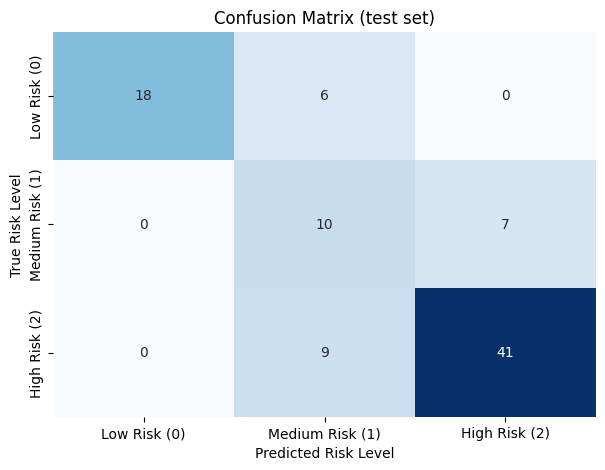

                                              Feature  Importance
8                    study_hours_per_week_11-15 hours    0.266453
10                    study_hours_per_week_6-10 hours    0.164327
11                                   cgpa_3.00 - 3.49    0.139060
9                      study_hours_per_week_16+ hours    0.093216
12                                   cgpa_3.50 - 3.74    0.086829
13                                   cgpa_3.75 - 4.00    0.080241
14                                    cgpa_Below 2.50    0.033338
7                    last_minute_exam_preparation_Yes    0.021628
20  hours_spent_on_mobile_non_academic_More than 4...    0.014296
16                use_of_time_management_Occasionally    0.013399


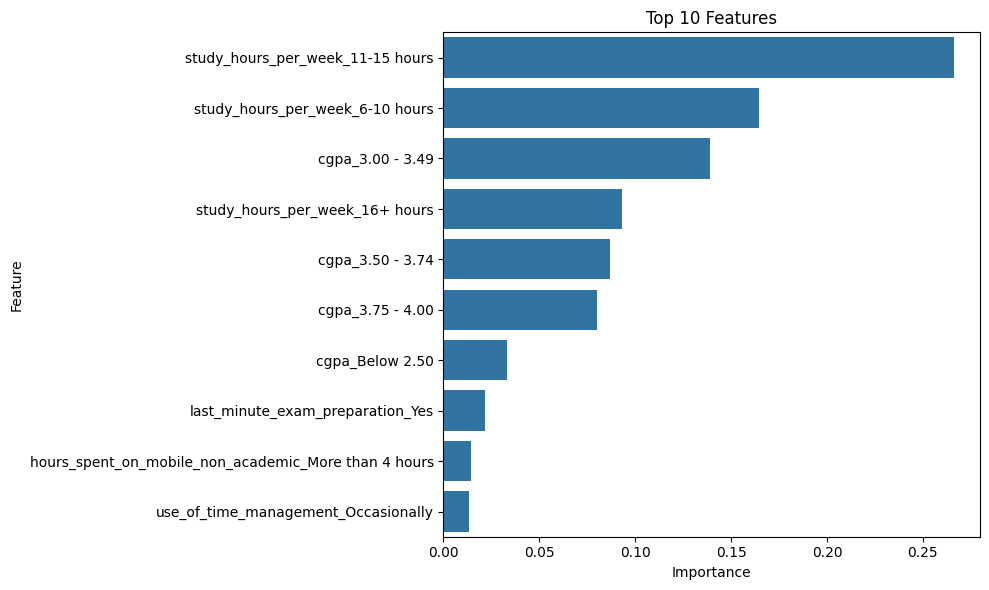

In [92]:
# predictiong auf dem Test Set
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}") # accuracy ausgeben
print("Test Set Classification Report (Realistic Features) --- ")
target_names_for_report = ["Low Risk (0)", "Medium Risk (1)", "High Risk (2)"]
print(classification_report(y_test, y_pred, target_names=target_names_for_report))
print("Test Set Confusion Matrix --- ")
cm = confusion_matrix(y_test, y_pred)

# confusion matrix visualisieren
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=target_names_for_report, yticklabels=target_names_for_report)
plt.xlabel("Predicted Risk Level")
plt.ylabel("True Risk Level")
plt.title("Confusion Matrix (test set)")
plt.show() 

# top 10 features anzeigen
importances = rf_model.feature_importances_
feature_df = pd.DataFrame({"Feature": X_test.columns, "Importance": importances})
feature_df = feature_df.sort_values("Importance", ascending=False)
print(feature_df.head(10))
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_df.head(10))
plt.title("Top 10 Features")
plt.tight_layout()
plt.show()


In [93]:
model_filename = "procrastination_risk_model.joblib"

# Modell abspeichern
joblib.dump(rf_model, model_filename)


['procrastination_risk_model.joblib']